# Importing Libraries

In [1]:
!pip install seaborn

In [2]:
!pip install tensorflow==2.8 

In [3]:
!pip install protobuf==3.20.*

In [4]:
!pip install scipy

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


In [23]:
!pip install opencv-python
!pip install PyQt5

   ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.9 MB ? eta -:--:--
   --------- ------------------------------ 1.6/6.9 MB 4.9 MB/s eta 0:00:02
   ---------------- ----------------------- 2.9/6.9 MB 5.6 MB/s eta 0:00:01
   ------------------------- -------------- 4.5/6.9 MB 6.0 MB/s eta 0:00:01
   --------------------------------- ------ 5.8/6.9 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------  6.8/6.9 MB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 6.9/6.9 MB 5.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/50.1 MB ? eta -:--:--
    --------------------------------------- 0.8/50.1 MB 3.7 MB/s eta 0:00:14
   - -------------------------------------- 1.6/50.1 MB 4.2 MB/s eta 0:00:12
   - -------------------------------------- 2.4/50.1 MB 3.7 MB/s eta 0:00:13
   -- ------------------------------------- 2.6/50.1 MB 3.4 MB/s eta 0:00:14
   -- ----------------------

# Displaying Images

In [6]:
picture_size = 48
folder_path = "../input/face-expression-recognition-dataset/images/C:/emotion detection/emotion final/fer2013.csv"

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
✅ Found 547 images for expression 'Disgust' (label 1)


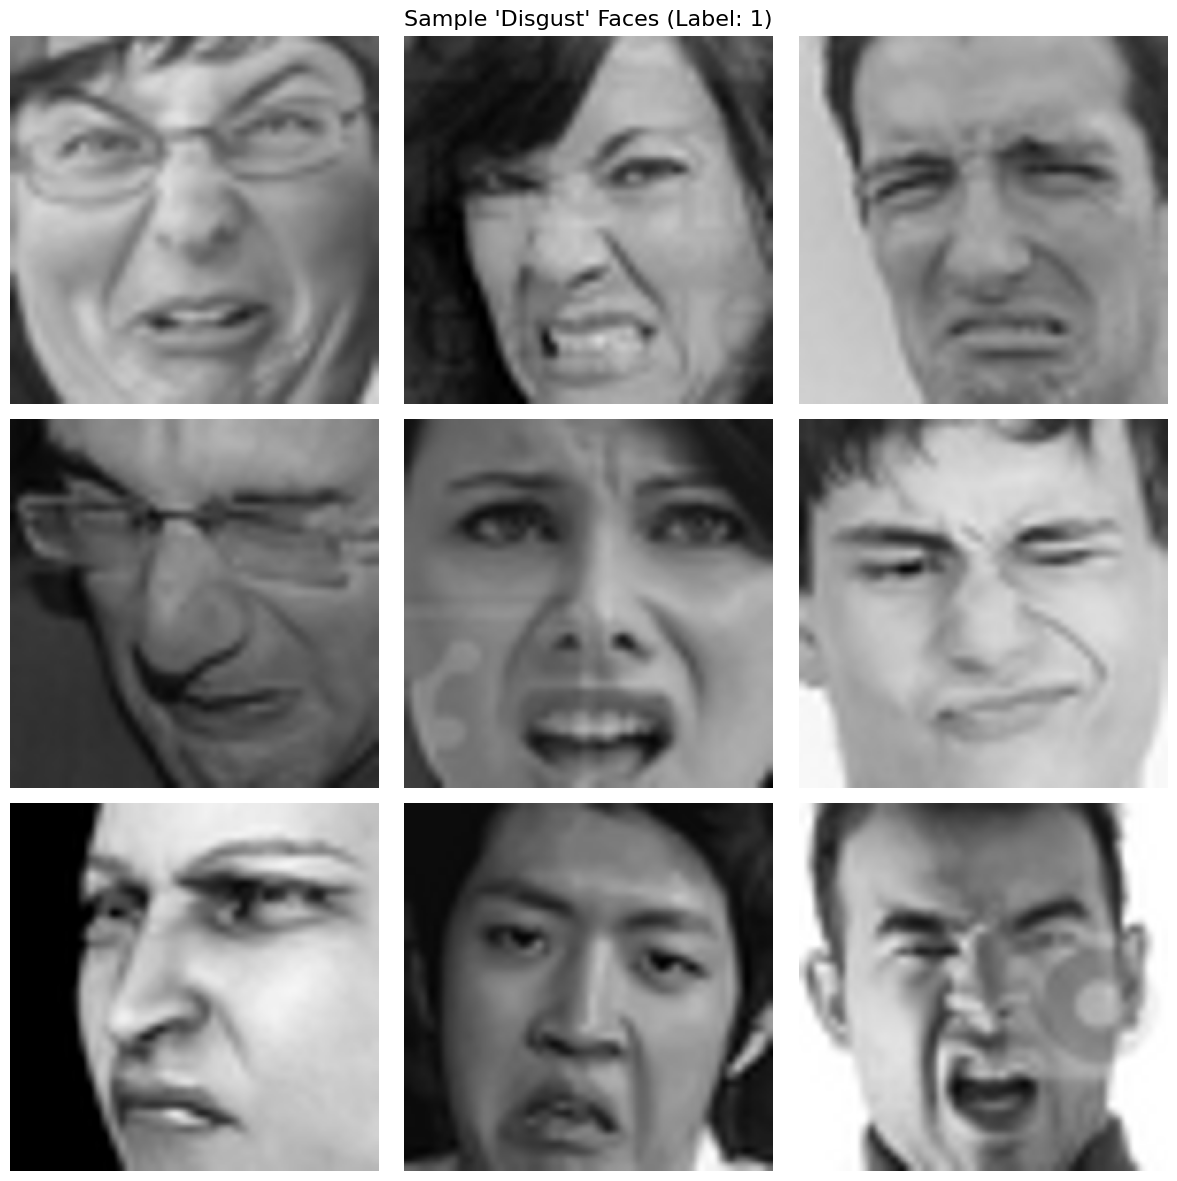

In [7]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

# === CONFIGURATION ===
# Absolute path to the folder (use raw string to avoid backslash issues)
folder_path = r'C:\Users\mukul\emotion final'
csv_path = os.path.join(folder_path, 'fer2013.csv')  # full path to CSV

# Image resize target
picture_size = 224  

# === LOAD DATA ===
# Load the CSV file containing emotion labels and pixel data
try:
    df = pd.read_csv(csv_path)
    print(df.head())
except FileNotFoundError:
    print(f"❌ File not found at: {csv_path}")
    exit()

# === FILTER: 'Disgust' Emotion ===
expression_label = 1  # Label for 'Disgust'
expression_name = 'Disgust'

# Filter the dataset to only the chosen expression
expression_data = df[df['emotion'] == expression_label]
print(f"✅ Found {len(expression_data)} images for expression '{expression_name}' (label {expression_label})")

# === PLOT ===
plt.figure(figsize=(12, 12))

for i in range(min(9, len(expression_data))):  
    plt.subplot(3, 3, i + 1)

    # Get pixel string and convert to 48x48 image
    pixel_str = expression_data.iloc[i]['pixels']
    pixels = np.array(pixel_str.split(), dtype='float32').reshape(48, 48)

    # Convert to image and resize
    img = Image.fromarray(pixels)
    img_resized = img.resize((picture_size, picture_size))

    # Show image
    plt.imshow(img_resized, cmap='gray')
    plt.axis('off')

plt.suptitle(f"Sample '{expression_name}' Faces (Label: {expression_label})", fontsize=16)
plt.tight_layout()
plt.show()


# Making Training and Validation Data

In [8]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuration
batch_size = 32
picture_size = 48  # Image resolution: 48x48

# Base path (update this if needed)
folder_path = r'C:\Users\mukul\emotion final'
train_dir = os.path.join(folder_path, 'train')
val_dir = os.path.join(folder_path, 'validation')

# Check if folders exist
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"🚫 Training folder not found at: {train_dir}")
if not os.path.exists(val_dir):
    raise FileNotFoundError(f"🚫 Validation folder not found at: {val_dir}")

print("✅ Found both 'train' and 'validation' directories.")  
# Initialize ImageDataGenerators
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)

# Load image data
train_set = datagen_train.flow_from_directory(
    train_dir,
    target_size=(picture_size, picture_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_set = datagen_val.flow_from_directory(
    val_dir,
    target_size=(picture_size, picture_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
 

✅ Found both 'train' and 'validation' directories.
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Model Building

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
def build_cnn(input_shape=(48, 48, 1), num_classes=7):
    model = models.Sequential()

    # Conv Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Layer 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))  

    # Flatten and Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model Summary
cnn_model = build_cnn(input_shape=(48, 48, 1), num_classes=7)
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

# Fitting the Model with Training and Validation Data 

In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# 2. Settings
picture_size = 48
batch_size = 32
num_classes = 7

# 3. Data generators (✔ rotation removed to avoid scipy dependency)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True  # safe without scipy
)

test_datagen = ImageDataGenerator(rescale=1./255)

# 4. Load datasets
train_path = r'C:\Users\mukul\emotion final\train'
val_path = r'C:\Users\mukul\emotion final\validation'

train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(picture_size, picture_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_set = test_datagen.flow_from_directory(
    val_path,
    target_size=(picture_size, picture_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# 5. Generator wrapper (casting to float32 for mixed precision compatibility)
def generator(data_gen):
    while True:
        x, y = data_gen.next()
        yield x.astype(np.float32), y.astype(np.float32)

# 6. Create tf.data.Dataset
train_set_tf = tf.data.Dataset.from_generator(
    lambda: generator(train_set),
    output_signature=(
        tf.TensorSpec(shape=(None, picture_size, picture_size, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
)

test_set_tf = tf.data.Dataset.from_generator(
    lambda: generator(test_set),
    output_signature=(
        tf.TensorSpec(shape=(None, picture_size, picture_size, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
)

# 7. Convert grayscale to RGB (needed for standard CNN input)
def convert_grayscale_to_rgb(x, y):
    return tf.image.grayscale_to_rgb(x), y

AUTOTUNE = tf.data.AUTOTUNE
train_set_tf = train_set_tf.map(convert_grayscale_to_rgb).cache().prefetch(AUTOTUNE)
test_set_tf = test_set_tf.map(convert_grayscale_to_rgb).cache().prefetch(AUTOTUNE)

# 8. Callbacks
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# 9. Build CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(48, 48, 1)),  # ✅ Corrected input shape
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Re-compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model ready. You can now train using `model.fit(...)`")


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
✅ Model ready. You can now train using `model.fit(...)`


In [14]:
for x, y in train_set_tf.take(1):
    print("x shape:", x.shape)
    print("y shape:", y.shape)
# Train the model

x shape: (32, 48, 48, 3)
y shape: (32, 7)


In [18]:
history = model.fit(
    train_set,  # ✅ Use original generator
    validation_data=test_set,
    epochs=3,
    steps_per_epoch=train_set.samples // batch_size,
    validation_steps=test_set.samples // batch_size,
    callbacks=callbacks_list,
    verbose=1
)
# Evaluate the model

Epoch 1/3
897/897 [==============================] - 70764s 79s/step - loss: 1.6952 - accuracy: 0.3285 - val_loss: 1.6112 - val_accuracy: 0.3711 - lr: 1.0000e-04
Epoch 2/3
897/897 [==============================] - 10947s 12s/step - loss: 1.5699 - accuracy: 0.3969 - val_loss: 1.5350 - val_accuracy: 0.4129 - lr: 1.0000e-04
Epoch 3/3
897/897 [==============================] - 8095s 9s/step - loss: 1.5004 - accuracy: 0.4257 - val_loss: 1.4691 - val_accuracy: 0.4379 - lr: 1.0000e-04


In [ ]:
model.save('emotion_model.h5')


# Plotting Accuracy & Loss

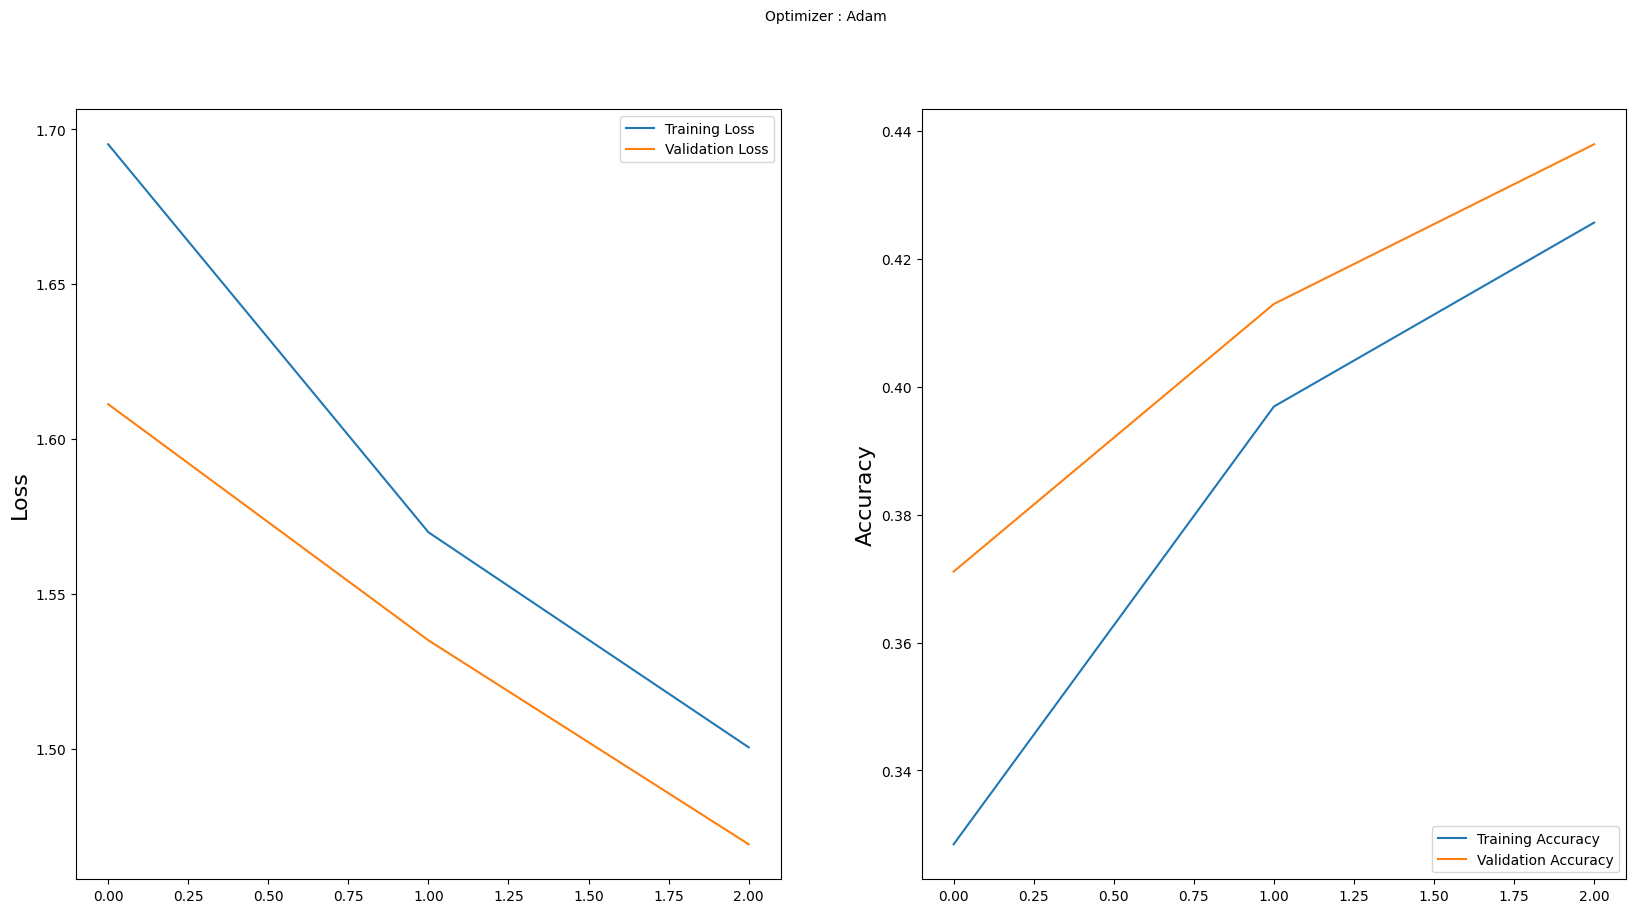

In [19]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [1]:
import sys
import os
import cv2
import numpy as np
from PyQt5.QtWidgets import QApplication, QLabel, QMainWindow, QPushButton, QVBoxLayout, QWidget, QMessageBox
from PyQt5.QtCore import QTimer, Qt
from PyQt5.QtGui import QImage, QPixmap, QFont
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import img_to_array

class EmotionDetector(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Emotion Detector")
        self.setFixedSize(800, 600)
        self.setStyleSheet("background-color: #1e1e1e; color: #ffffff;")

        # Verify model and classifier files
        if not os.path.exists("emotion_model.h5") or not os.path.exists("haarcascade_frontalface_default.xml"):
            QMessageBox.critical(self, "Error", "Required files are missing.\nPlease ensure 'emotion_model.h5' and 'haarcascade_frontalface_default.xml' exist.")
            sys.exit(1)

        self.face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        self.model = load_model('emotion_model.h5')
        self.emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
        self.highlight_color = (0, 255, 255)

        self.label = QLabel("Camera feed will appear here.")
        self.label.setAlignment(Qt.AlignCenter)
        self.label.setFont(QFont("Segoe UI", 14, QFont.Bold))
        self.label.setStyleSheet("""
            border-radius: 20px;
            background-color: #333333;
            border: 1px solid #444444;
            padding: 10px;
        """)

        self.button_start = QPushButton("Start Camera")
        self.button_start.setFont(QFont("Segoe UI", 10, QFont.Bold))
        self.button_start.setStyleSheet("""
            QPushButton {
                background-color: #2f80ed;
                color: white;
                border: none;
                border-radius: 10px;
                padding: 10px 20px;
            }
            QPushButton:hover {
                background-color: #1c6dd0;
            }
        """)

        self.button_stop = QPushButton("Stop Camera")
        self.button_stop.setFont(QFont("Segoe UI", 10, QFont.Bold))
        self.button_stop.setStyleSheet("""
            QPushButton {
                background-color: #eb5757;
                color: white;
                border: none;
                border-radius: 10px;
                padding: 10px 20px;
            }
            QPushButton:hover {
                background-color: #cc4c4c;
            }
        """)

        self.button_start.clicked.connect(self.start_camera)
        self.button_stop.clicked.connect(self.stop_camera)

        layout = QVBoxLayout()
        layout.addWidget(self.label)
        layout.addWidget(self.button_start)
        layout.addWidget(self.button_stop)

        container = QWidget()
        container.setLayout(layout)
        self.setCentralWidget(container)

        self.cap = None
        self.timer = QTimer()
        self.timer.timeout.connect(self.update_frame)

    def start_camera(self):
        self.cap = cv2.VideoCapture(0)
        if not self.cap.isOpened():
            QMessageBox.critical(self, "Error", "Could not access the webcam.")
            return
        self.timer.start(30)

    def stop_camera(self):
        self.timer.stop()
        if self.cap:
            self.cap.release()
        self.label.setText("Camera stopped.")
        self.label.setPixmap(QPixmap())  # Clear video frame

    def update_frame(self):
        ret, frame = self.cap.read()
        if not ret:
            return

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_classifier.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            roi_gray = gray[y:y + h, x:x + w]
            roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)
            roi_rgb = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2RGB)

            if np.sum([roi_gray]) != 0:
                roi = roi_rgb.astype('float') / 255.0
                roi = img_to_array(roi)
                roi = np.expand_dims(roi, axis=0)
                prediction = self.model.predict(roi, verbose=0)[0]
                label = self.emotion_labels[prediction.argmax()]
                label_position = (x, y - 10)

                cv2.putText(frame, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.9, self.highlight_color, 2)
                cv2.rectangle(frame, (x, y), (x + w, y + h), self.highlight_color, 2)

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = QImage(frame.data, frame.shape[1], frame.shape[0], QImage.Format_RGB888)
        self.label.setPixmap(QPixmap.fromImage(img).scaled(self.label.size(), Qt.KeepAspectRatio, Qt.SmoothTransformation))

if __name__ == "__main__":
    app = QApplication(sys.argv)
    window = EmotionDetector()
    window.show()
    sys.exit(app.exec_())


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


SystemExit: 0

c:\Users\mukul\emotion final\.venv\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
